In [1]:
import pymc as pm
import numpy as np
import arviz as az
from pymc.math import logit, exp
import matplotlib.pyplot as plt
import xarray as xr

%load_ext lab_black
%load_ext watermark

# Priors as hidden mixtures

Adapted from [Unit 9: cumulative2.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/cumulative2.odc).

Associated lecture video: Unit 9 lesson 8

## Problem description

Use of ```cumulative``` as a check for outliers

How consistent are the data with the model? Check ```cumulative(y[i], y[i])```.

The first y[i] specifies the distribution of y[i]'s, the second is the argument/observation. The output is empirical cdf of y[i]s evaluated at y[i].

Values close to 0 or 1 are potential outliers.

## Notes

The idea here seems to be based on the [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform). The problem I'm having is I don't know exactly how the BUGS ```cumulative``` function works - it doesn't seem to be in the docs. Is it using KDE to approximate the cdf or what?

For now, I recommend checking out plots like the examples below to look for outliers. I'll try to come back to this example in the future.

In [2]:
# fmt: off
y = np.array(
    [0.0, 1.0, 2.0, -1.0, 0.4, -0.5, 0.7, -1.2, 0.1, -0.4, 
     0.2, -0.5, -1.4, 1.8, 0.2, 0.3, -0.6, 1.1, 5.1, -6.3]
)
# fmt: on

In [3]:
with pm.Model() as m:
    theta = pm.Flat("theta")
    log_sigma = pm.Flat("log_sigma")
    tau = pm.Deterministic("tau", 1 / exp(2 * log_sigma))

    pm.Normal("y", mu=theta, tau=tau, observed=y)

    trace = pm.sample(2000)

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y]


In [4]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.050,0.493,-0.852,0.993,0.006,0.006,6344.0,5145.0,1.0
log_sigma,0.758,0.170,0.443,1.076,0.002,0.002,5848.0,5204.0,1.0
tau,0.232,0.077,0.097,0.379,0.001,0.001,5848.0,5204.0,1.0


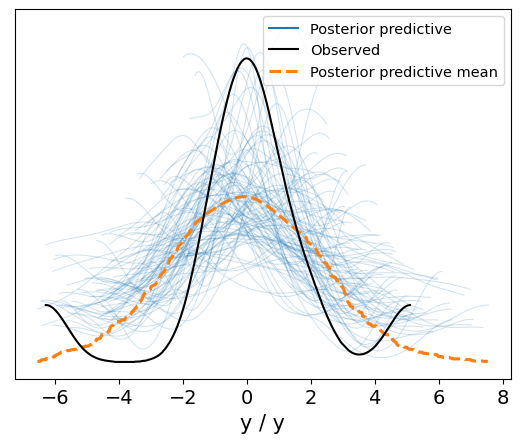

In [5]:
az.plot_ppc(trace, num_pp_samples=100)
plt.show()

Doesn't look like our posterior does a good job of fitting the observed data because of the outliers.

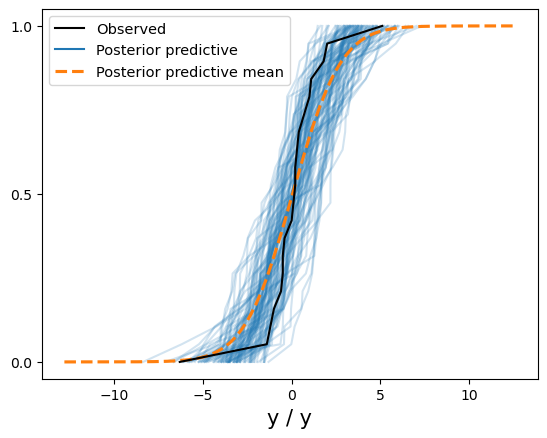

In [6]:
az.plot_ppc(trace, kind="cumulative", num_pp_samples=100)
plt.show()

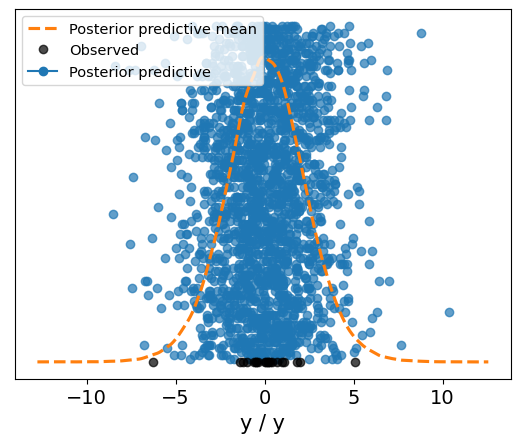

In [7]:
az.plot_ppc(trace, kind="scatter", num_pp_samples=100)
plt.show()

The below code is not working for me since PyMC 5, and neither is the ```plot_lm``` [example code](https://python.arviz.org/en/0.14.0/api/generated/arviz.plot_lm.html). I'll keep an eye out for when it gets fixed.

In [ ]:
idx = list(range(20))

az.plot_lm(
    idata=trace,
    y="y",
    x=idx,
    plot_dim="y_dim_0",
    kind_model="hdi",
    textsize=8,
)
plt.xlabel("observed index")
plt.xticks(idx)
plt.show()

In [8]:
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Fri Feb 03 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

aesara: 2.8.10
aeppl : 0.1.1

matplotlib: 3.6.3
arviz     : 0.14.0
numpy     : 1.24.1
pymc      : 5.0.1
xarray    : 2023.1.0

